# Imports

In [2]:
import warnings
import numpy as np
import pandas as pd
from scipy.io import arff
import scipy as sp
import os
import struct
import skdim
import matplotlib.pyplot as plt
import sklearn.datasets as skdata
import repliclust
import sklearn.neighbors as sknn
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split               
import json
from PIL import Image
from kisomap import KIsomap, Clustering, ConstrainedKIsomap
from matplotlib.pyplot import cm
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding
import umap.umap_ as umap
from sklearn.datasets import fetch_olivetti_faces
from sklearn.mixture import GaussianMixture
import openai
import logging

# To avoid unnecessary warning messages
openai._utils._logs.logger.setLevel(logging.WARNING)
warnings.simplefilter(action='ignore')

Failed to initialize OpenAI client. Either put OPENAI_API_KEY=<...> into the .env file or pass openai_api_key=<...> as an argument in a function call.


# Functions

In [4]:
# Função para comparar os métodos e plotar numa única figura
def compare_and_plot_surface_reduction(X,color,dataset_name):

    k = int(np.floor(np.sqrt(X.shape[0]))) 

    methods = {
        'ISOMAP': Isomap(n_components=2, n_neighbors=k),
        'KPCA': KernelPCA(n_components=2, kernel='rbf'),
        'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=k),
        'Laplacian Eigenmaps': SpectralEmbedding(n_components=2, n_neighbors=k,affinity='rbf'),
        't-SNE': TSNE(n_components=2),
        'UMAP': umap.UMAP(n_components=2, n_neighbors=k),
        'K-ISOMAP': KIsomap
    }

    fig = plt.figure(figsize=(18, 3))  # Figura maior para múltiplas subplots
    #color = [cm.rainbow(valor) for valor in np.linspace(0,1,X.shape[0])]
    # Plotando a superfície original em R^3
    ax = fig.add_subplot(1, 8, 1, projection='3d')
    #ax.view_init(azim=90,elev=-70)
    ax.view_init(azim=30,elev=30)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, marker='.')
    ax.set_title(dataset_name)
    ax.set_box_aspect((1, 1, 1), zoom=1.5)
    ax.grid(False)
    ax.axis(False)
    
    print('n: ', X.shape[0])

    # Aplicar cada método e plotar a projeção em 2D
    for idx, (name, model) in enumerate(methods.items(), start=2):
        print(name)
        if name == 'K-ISOMAP':
            X_transformed, _ = model(X,k,2,'norm')
            ax = fig.add_subplot(1, 8, idx)
            ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, marker='.')
            ax.set_title(f'{name}')
            ax.grid(False)
            ax.axis(False)
        else:
            X_transformed = model.fit_transform(X)
            ax = fig.add_subplot(1, 8, idx)
            ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, marker='.')
            ax.set_title(f'{name}')
            ax.grid(False)
            ax.axis(False)
        
    plt.show()
    plt.savefig('S_Surface.jpg', dpi=300)

In [121]:
# Função para comparar os métodos e plotar numa única figura
def compare_and_plot_option_kisomap(X,color,dataset_name):

    k = int(np.floor(np.sqrt(X.shape[0]))) - 20

    methods = {
        'norm': ConstrainedKIsomap,
        'first': ConstrainedKIsomap,
        'last': ConstrainedKIsomap,
        'avg(first,last)': ConstrainedKIsomap,
        'mean': ConstrainedKIsomap,
        'max': ConstrainedKIsomap,
        'min': ConstrainedKIsomap,
        'min*max': ConstrainedKIsomap,
        'max-min': ConstrainedKIsomap,
        'exp': ConstrainedKIsomap,
        'mixed': ConstrainedKIsomap,
    }

    options = ['norm','first','last','avg_first_last','mean','max','min','product_min_max','difference_max_min','exponential','mixed']


    fig = plt.figure(figsize=(18, 3))  # Figura maior para múltiplas subplots
    #color = [cm.rainbow(valor) for valor in np.linspace(0,1,X.shape[0])]
    # Plotando a superfície original em R^3
    ax = fig.add_subplot(1, 12, 1, projection='3d')
    #ax.view_init(azim=90,elev=-70)
    ax.view_init(azim=30,elev=30)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, marker='.')
    ax.set_title(dataset_name + '\n', pad=21)
    ax.set_box_aspect((1, 1, 1), zoom=1.5)
    ax.grid(False)
    ax.axis(False)
    
    print('n: ', X.shape[0])

    # Aplicar cada método e plotar a projeção em 2D
    for idx, (name, model) in enumerate(methods.items()):
        print(idx)
        X_transformed, _ = model(X,k,2,options[idx])
        ax = fig.add_subplot(1, 12, idx+2)
        ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, marker='.')
        ax.set_title(f'{name}')
        ax.grid(False)
        ax.axis(False)
        
    plt.show()
    plt.savefig('S_Surface.jpg', dpi=300)

In [18]:
def plot_kiso_iterations(X, color, dataset_name):
    # Calculate k as sqrt of number of points
    k = int(np.floor(np.sqrt(X.shape[0]))) - 20
    
    # Create figure with 2x5 subplot grid
    fig = plt.figure(figsize=(20, 8))
    
    print('Number of samples:', X.shape[0])
    
    # Create 10 projections with different i values
    for idx in range(10):
        print('value: ', idx/10)
        # Calculate subplot position (2 rows, 5 columns)
        ax = fig.add_subplot(2, 5, idx + 1)
        
        # Apply KISOMAP with current iteration value
        X_transformed, _ = ConstrainedKIsomap(X, k, 2, 'mixed',idx/10)
        
        # Create scatter plot
        ax.scatter(X_transformed[:, 0], X_transformed[:, 1], 
                  c=color, marker='.', alpha=0.6)
        
        # Set subplot title and styling
        ax.set_title(f'KISOMAP (alpha={idx/10})')
        ax.grid(False)
        ax.axis('off')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_kiso_iterations.jpg', dpi=300, bbox_inches='tight')
    plt.show()


# S-Surface

In [6]:
# Definição da superfície S com fórmulas baseadas em seno e cosseno
def surface_S(u, v):
    x = np.sin(2*u)
    z = v
    y = np.cos(u)
    return x, y, z

# Geração de pontos para a superfície
u = np.linspace(-0.3*np.pi, 1.3*np.pi, 30) 
u += np.random.normal(loc=0, scale=0.01, size=u.shape) # Parâmetro u
v = np.linspace(0, np.pi, 30) 
v += np.random.normal(loc=0, scale=0.01, size=v.shape)     # Parâmetro v
u, v = np.meshgrid(u, v)

x, y, z = surface_S(u, v)

# Adicionar o ruído às coordenadas
x_noisy = x + np.random.normal(loc=0, scale=0.1, size=x.shape)
y_noisy = y + np.random.normal(loc=0, scale=0.1, size=y.shape)
z_noisy = z + np.random.normal(loc=0, scale=0.1, size=z.shape)

df = pd.DataFrame(np.array([x_noisy, y_noisy, z_noisy]).reshape(3, -1).T, columns=['x','y','z'])


Number of samples: 900
value:  0.0
value:  0.1
value:  0.2
value:  0.3
value:  0.4
value:  0.5
value:  0.6
value:  0.7
value:  0.8
value:  0.9


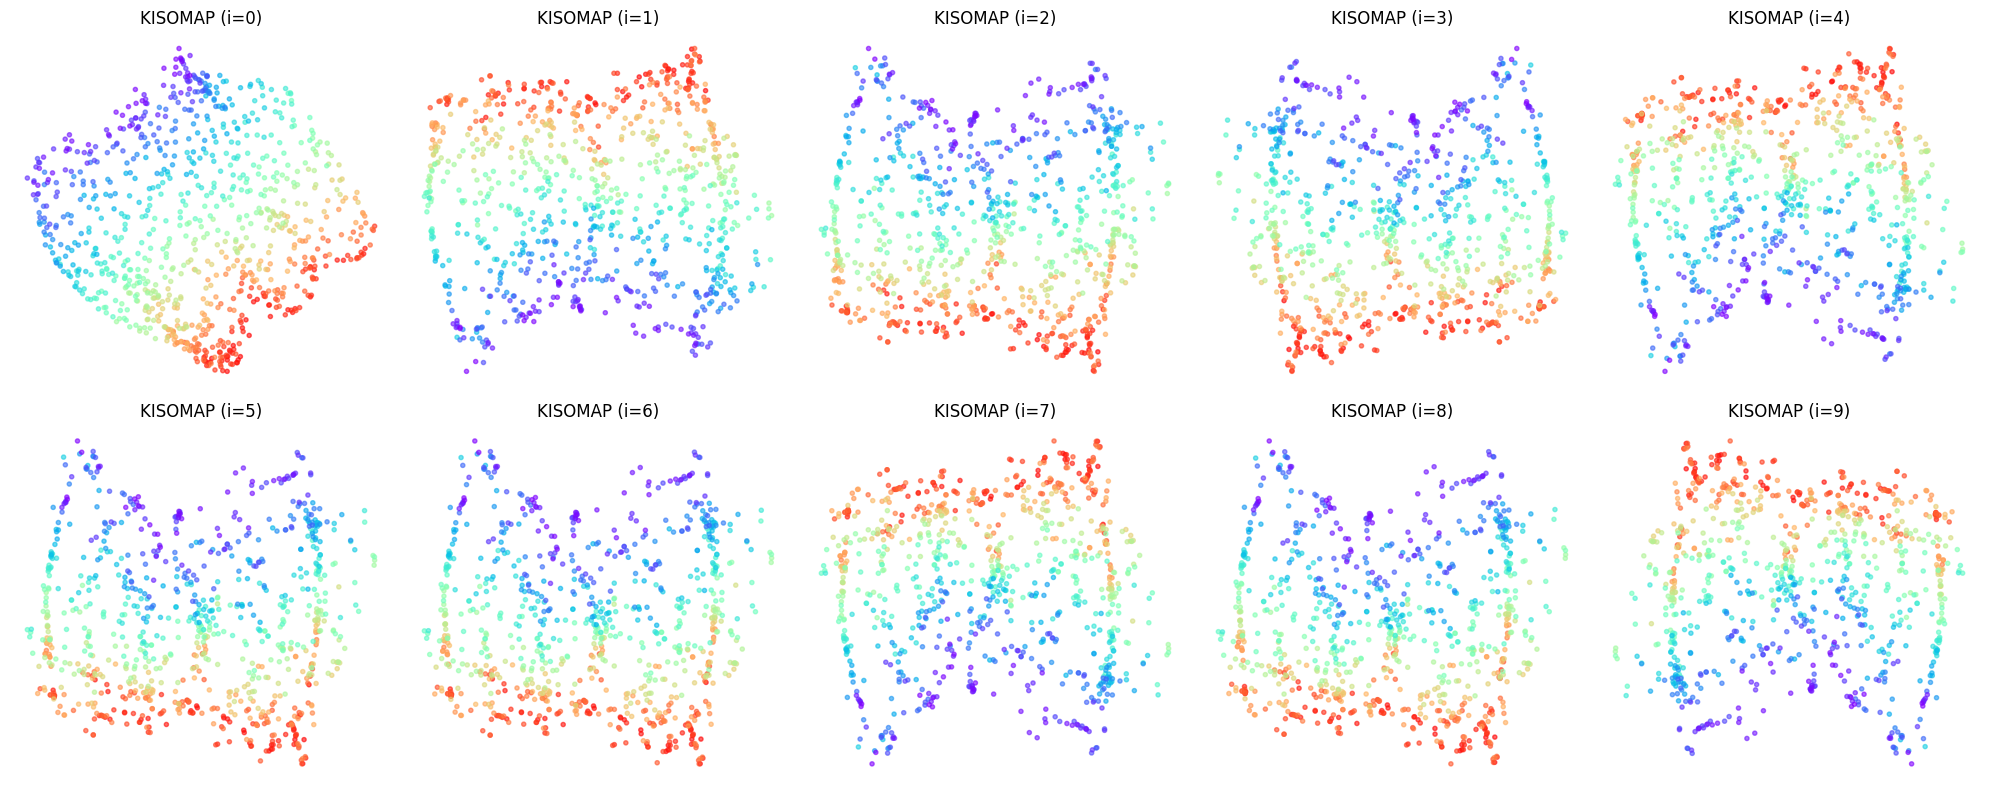

In [10]:
color = [cm.rainbow(1-valor) for valor in np.linspace(0,1,df.values.shape[0])]

plot_kiso_iterations(df.values,color,'S-shape surface')

## S Surface with Hole

In [17]:
new_df = df.loc[(df['x'] - np.mean(df['x']))**2 + (df['y'] - np.mean(df['y']))**2 + (df['z'] - np.mean(df['z']))**2 >= 0.8]

n:  839
ISOMAP
KPCA
LLE
Laplacian Eigenmaps
t-SNE
UMAP
K-ISOMAP


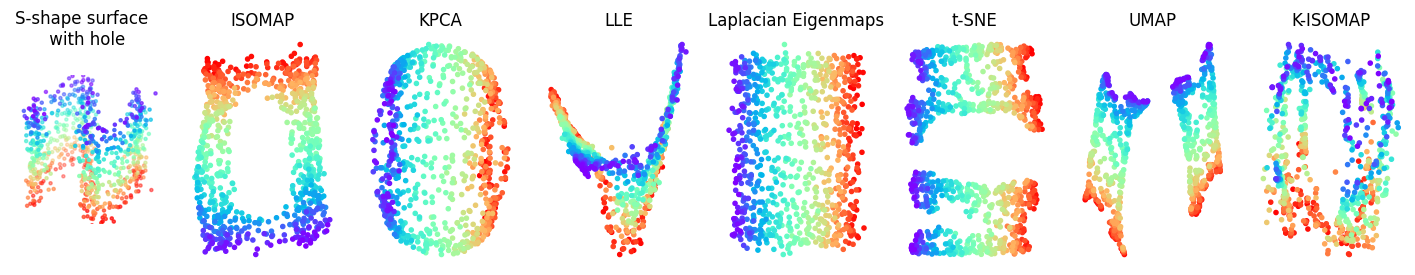

<Figure size 640x480 with 0 Axes>

In [18]:
color = [cm.rainbow(1-valor) for valor in np.linspace(0,1,new_df.values.shape[0])]

compare_and_plot_surface_reduction(new_df.values,color,'S-shape surface \n with hole')

## Uniform plot

In [412]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def compute_surface_area_element(u, v, du, dv):
    """
    Compute the surface area element at point (u,v)
    using the fundamental forms of differential geometry
    """
    # Partial derivatives
    dx_du = 2 * np.cos(2*u)
    dy_du = -np.sin(u)
    dz_du = 0
    
    dx_dv = 0
    dy_dv = 0
    dz_dv = 1
    
    # First fundamental form coefficients
    E = dx_du**2 + dy_du**2 + dz_du**2
    F = dx_du*dx_dv + dy_du*dy_dv + dz_du*dz_dv
    G = dx_dv**2 + dy_dv**2 + dz_dv**2
    
    # Surface area element
    return np.sqrt(E*G - F**2) * du * dv

def generate_uniform_surface_points(n_points=900, noise_scale=0.13):
    """
    Generate approximately uniform points on the S-shaped surface
    using importance sampling based on the surface area element
    
    Parameters:
    -----------
    n_points : int
        Number of points to generate
    noise_scale : float
        Standard deviation of the Gaussian noise to add
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the x, y, z coordinates of the points
    """
    # Initialize arrays for accepted points
    points_u = []
    points_v = []
    
    # Generate a fine grid for numerical integration
    u_fine = np.linspace(-0.3*np.pi, 1.3*np.pi, 100)
    v_fine = np.linspace(0, np.pi, 100)
    du = u_fine[1] - u_fine[0]
    dv = v_fine[1] - v_fine[0]
    
    # Compute surface area elements on the fine grid
    u_grid, v_grid = np.meshgrid(u_fine, v_fine)
    area_elements = compute_surface_area_element(u_grid, v_grid, du, dv)
    
    # Normalize to create probability distribution
    prob_dist = area_elements / np.sum(area_elements)
    
    # Generate points using rejection sampling
    while len(points_u) < n_points:
        # Sample u and v based on the probability distribution
        indices = np.random.choice(prob_dist.size, size=1, p=prob_dist.flatten())
        u_idx, v_idx = np.unravel_index(indices, prob_dist.shape)
        
        u_sample = u_fine[u_idx[0]] + np.random.uniform(-du/2, du/2)
        v_sample = v_fine[v_idx[0]] + np.random.uniform(-dv/2, dv/2)
        
        points_u.append(u_sample)
        points_v.append(v_sample)
    
    # Convert to numpy arrays
    points_u = np.array(points_u)
    points_v = np.array(points_v)
    
    # Generate surface points
    x = np.sin(2*points_u)
    y = np.cos(points_u)
    z = points_v
    
    # Add noise
    x_noisy = x + np.random.normal(loc=0, scale=noise_scale, size=x.shape)
    y_noisy = y + np.random.normal(loc=0, scale=noise_scale, size=y.shape)
    z_noisy = z + np.random.normal(loc=0, scale=noise_scale, size=z.shape)
    
    # Create DataFrame
    df = pd.DataFrame({
        'x': x_noisy,
        'y': y_noisy,
        'z': z_noisy
    })
    
    return df

def check_uniformity(df, n_neighbors=10):
    """
    Check the uniformity of the point distribution by computing
    the standard deviation of nearest neighbor distances
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the x, y, z coordinates
    n_neighbors : int
        Number of nearest neighbors to consider
        
    Returns:
    --------
    float
        Standard deviation of nearest neighbor distances
    """
    points = df[['x', 'y', 'z']].values
    distances = squareform(pdist(points))
    
    # For each point, get the mean distance to its n nearest neighbors
    neighbor_distances = []
    for i in range(len(points)):
        dist_to_neighbors = np.sort(distances[i])[1:n_neighbors+1].mean()
        neighbor_distances.append(dist_to_neighbors)
    
    return np.std(neighbor_distances)

In [413]:
df = generate_uniform_surface_points()

In [414]:
check_uniformity(df)

0.06537171072672936

# Gaussian Dataset

In [24]:
archetype = repliclust.Archetype(
    min_overlap=0.01, max_overlap=0.05,
    dim=3,
    n_samples=1100,
    distributions=[('gamma', {'shape': 1, 'scale': 2.0})]
)

# Gaussian Dataset
#archetype = repliclust.Archetype(
#                    dim=3,
#                    n_samples=1100,
#                    max_overlap=0.00001, min_overlap=0.000004 ,name="oblong"
#                    )
X1, y1, _ = (repliclust.DataGenerator(archetype).synthesize(quiet=True))

X1 = X1.astype(np.float64)

# Parameters
noise_scale = 1  # adjust the noise gaussian parameter here

# Add noise
# Definir a magnitude do ruído gaussiano
magnitude = np.linspace(0,1,26)
# Gerar ruído gaussiano com média zero e desvio padrão baseado na magnitude
ruido = np.random.normal(0, scale=magnitude[0], size=X1.shape)
# Adicionar o ruído aos dados
# Surface equation
X1.T[0] = X1.T[0] + ruido.T[0]
X1.T[1] = X1.T[1] + ruido.T[1]
X1.T[2] = X1.T[2] + ruido.T[2]

# Create DataFrame with x, y, z and label
df = pd.DataFrame({
    'x': X1[:, 0],  # First column of X1
    'y': X1[:, 1],  # Second column of X1
    'z': X1[:, 2],  # Third column of X1
    'label': y1     # Label data
})

In [25]:
my_min_val = np.min(y1)
my_max_val = np.max(y1)

# Perform min-max normalization
my_normalized_arr = (y1 - my_min_val) / (my_max_val - my_min_val)

Number of samples: 1100
value:  0.0
value:  0.1
value:  0.2
value:  0.3
value:  0.4
value:  0.5
value:  0.6
value:  0.7
value:  0.8
value:  0.9


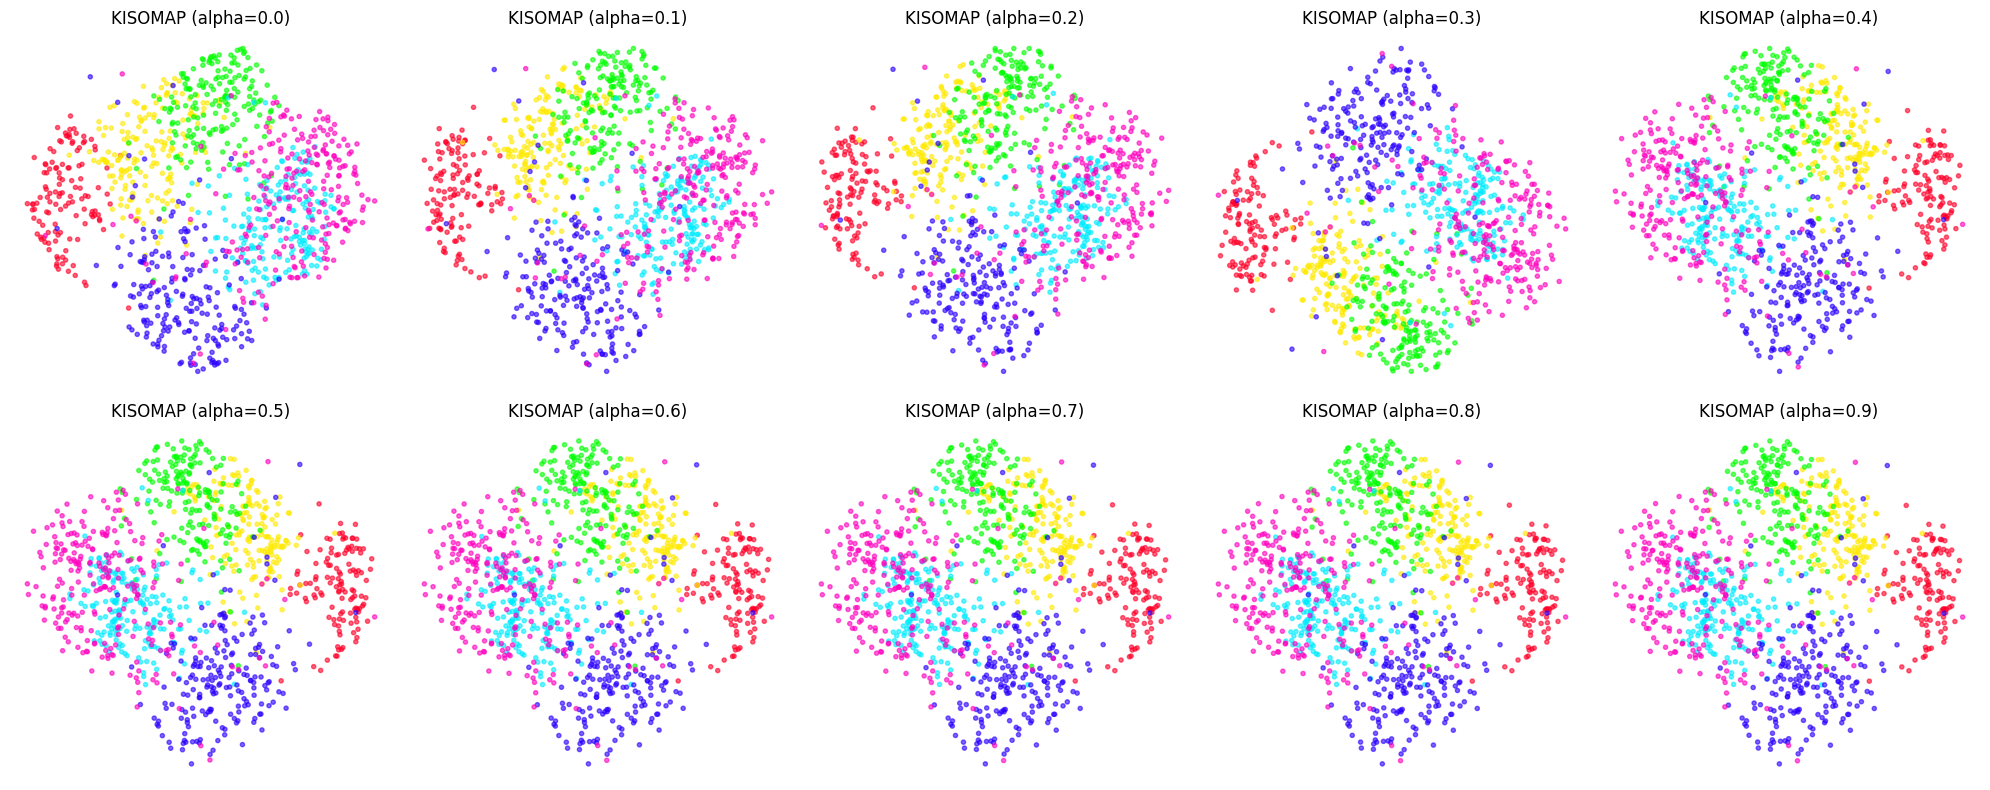

In [26]:
my_min_val = np.min(y1)
my_max_val = np.max(y1)

# Perform min-max normalization
my_normalized_arr = (y1 - my_min_val) / (my_max_val - my_min_val)

color = [cm.gist_rainbow(valor) for valor in my_normalized_arr]

# Comparar e plotar os métodos de redução de dimensionalidade
plot_kiso_iterations(X1,color,'Synthetic Data')

# Pen Digits 

In [2]:
# Reading .tra file
train_data = pd.read_csv('C:/Users/Gustavo/Documents/Mestrado/curvature-based-isomap/datasets/pen-digits/pendigits.tra',header=None)  # Add parameters as needed

# Reading .tes file
test_data = pd.read_csv('C:/Users/Gustavo/Documents/Mestrado/curvature-based-isomap/datasets/pen-digits/pendigits.tes',header=None)  # Add parameters as needed

In [3]:
# Separando dados e rótulos no conjunto de treino
X_train = train_data.iloc[:, :-1]  # Todas as colunas exceto a última
y_train = train_data.iloc[:, -1]   # Apenas a última coluna

# Separando dados e rótulos no conjunto de teste
X_test = test_data.iloc[:, :-1]    # Todas as colunas exceto a última
y_test = test_data.iloc[:, -1]     # Apenas a última coluna

In [4]:
pen_digits = {'data': X_train, 'target': y_train, 'details': {'name':'Pen-Digits'}}

# Mnist

In [5]:
def read_idx1_ubyte(file_path):
    with open(file_path, 'rb') as file:
        magic_number = struct.unpack('>I', file.read(4))[0]
        if magic_number != 2049:
            raise ValueError(f"Invalid magic number {magic_number} in file {file_path}")
        num_items = struct.unpack('>I', file.read(4))[0]
        labels = np.frombuffer(file.read(), dtype=np.uint8)
        if labels.size != num_items:
            raise ValueError("Mismatch in label count")
        return labels

def read_idx3_ubyte(file_path):
    with open(file_path, 'rb') as file:
        magic_number = struct.unpack('>I', file.read(4))[0]
        if magic_number != 2051:
            raise ValueError(f"Invalid magic number {magic_number} in file {file_path}")
        
        num_images = struct.unpack('>I', file.read(4))[0]
        num_rows = struct.unpack('>I', file.read(4))[0]
        num_cols = struct.unpack('>I', file.read(4))[0]
        
        images = np.frombuffer(file.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
        return images

labels_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\mnist\train-labels.idx1-ubyte'
images_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\mnist\train-images.idx3-ubyte'  # Substitua pelo caminho do seu arquivo

labels = read_idx1_ubyte(labels_path)
images = read_idx3_ubyte(images_path)

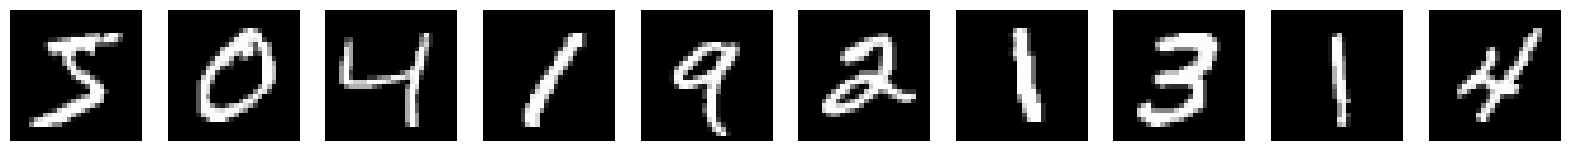

In [5]:
plt.figure(figsize=[20, 5])

# Plot the first 10 images
for i in range(10):
    image_row = images[i]
    image_reshaped = image_row.reshape(28, 28)
    
    plt.subplot(1, 10, i+1)  # Create a grid to plot 5 images side by side
    plt.imshow(image_reshaped, cmap='gray')
    plt.axis('off')  # Hide axes

plt.show()

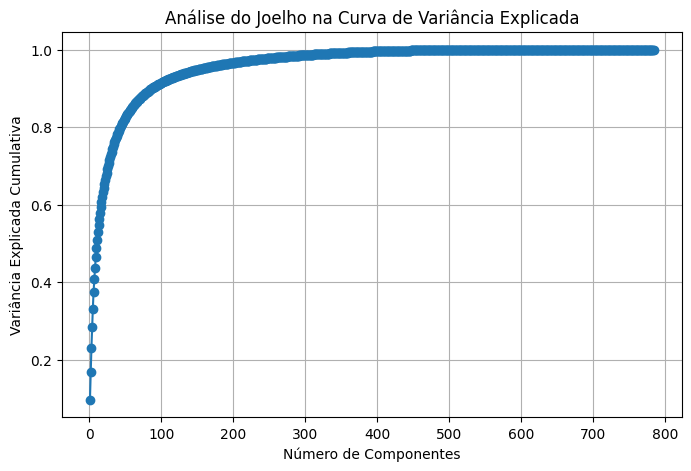

In [37]:
X = images

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()


In [6]:
mnist = {'data': images, 'target': labels, 'details': {'name':'MNIST'}}

# F-mnist

In [2]:
# Reading .tra file
train_data = pd.read_csv(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\f-mnist\fashion-mnist_train.csv')  # Add parameters as needed

# Reading .tes file
test_data = pd.read_csv(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\f-mnist\fashion-mnist_test.csv')  # Add parameters as needed

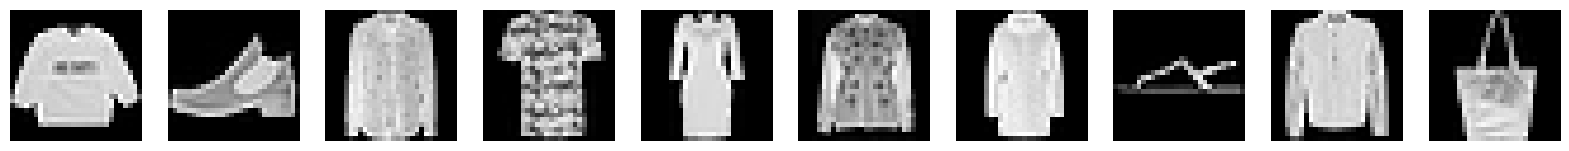

In [3]:
plt.figure(figsize=[20, 5])

# Plot the first 10 images
for i in range(10):
    image_row = np.array(train_data.drop(columns=['label']))[i]
    image_reshaped = image_row.reshape(28, 28)
    
    plt.subplot(1, 10, i+1)  
    plt.imshow(image_reshaped, cmap='gray')
    plt.axis('off')  # Hide axes

plt.show()

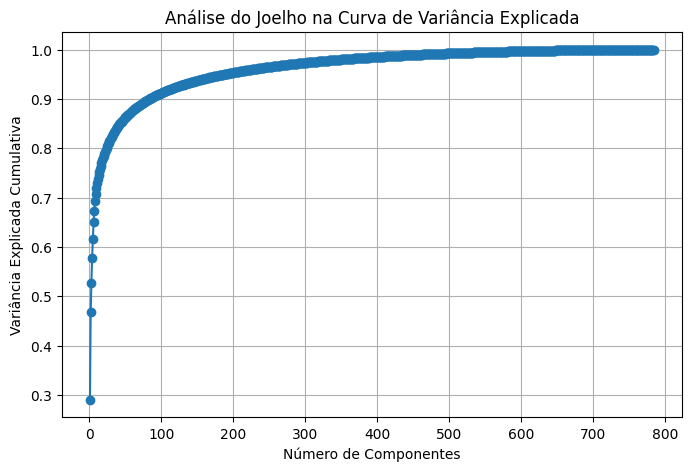

In [46]:
X = train_data.iloc[:,1:].values

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()


In [3]:
fmnist = {'data': train_data.iloc[:,1:].values, 'target': train_data['label'].values, 'details': {'name':'F-MNIST'}}

# Coil-20

In [505]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_num in range(1, 21):  # Pastas numeradas de 1 a 20
        class_folder = os.path.join(folder, str(class_num))
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img = Image.open(img_path).convert('L')  # Converter para escala de cinza
                    img_array = np.array(img).flatten()  # Flatten a imagem
                    images.append(img_array)
                    labels.append(class_num)
    return np.array(images), np.array(labels)

def create_dataframe(images, labels):
    data = np.column_stack((images, labels))
    columns = [f'pixel_{i}' for i in range(images.shape[1])] + ['label']
    df = pd.DataFrame(data, columns=columns)
    return df

folder_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\coil-20' 
images, labels = load_images_from_folder(folder_path)
dataset_df = create_dataframe(images, labels)

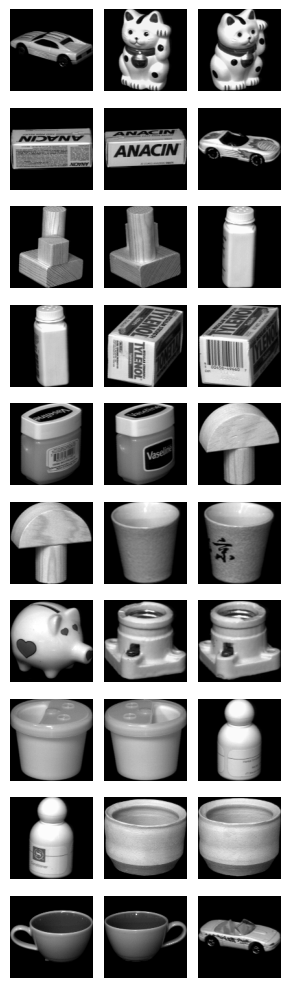

In [72]:
plt.figure(figsize=[3, 10])  # Ajuste o tamanho para caber o grid 2x5

for i in range(30):  # 10 imagens
    image_row = images[39*i + 200]
    image_reshaped = image_row.reshape(128, 128)

    plt.subplot(10, 3, i + 1)  # Criar grid 2x5 (2 linhas, 5 colunas)
    plt.imshow(image_reshaped, cmap='gray')
    plt.axis('off')  # Esconder os eixos

plt.tight_layout()  # Ajustar os espaços entre os subplots
plt.show()

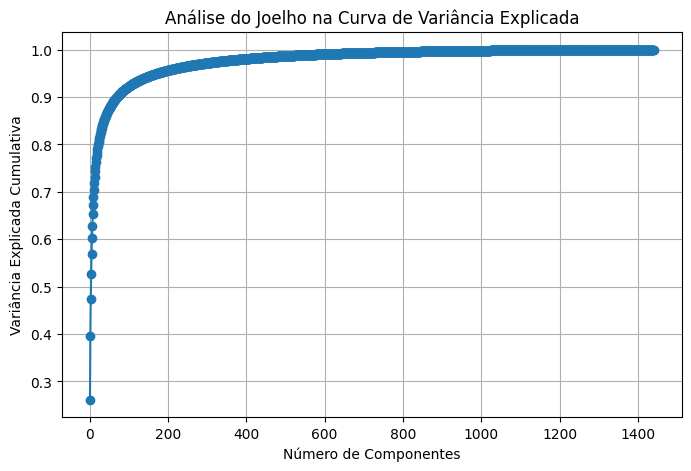

In [15]:
X = dataset_df.iloc[:,1:]

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()

In [506]:
coil_20 = {'data': dataset_df.iloc[:, :-1].values, 'target': dataset_df.iloc[:, -1].values, 'details': {'name':'coil-20'}}

# AP_Omentum_Kidney

In [11]:
# Carregar o arquivo ARFF
data, meta = arff.loadarff(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\AP_Omentum_Kidney\AP_Omentum_Kidney.arff')

# Converter para um DataFrame do pandas
df = pd.DataFrame(data)

In [12]:
labels = df['Tissue']

dataset = df.drop(['Tissue'],axis=1)

In [13]:
omentum_kidney = {'data': dataset, 'target': labels, 'details': {'name':'AP_Omentum_Kidney'}}

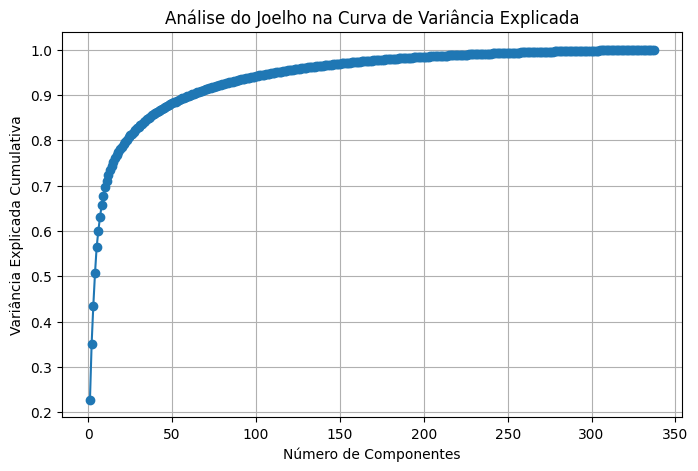

In [55]:
X = dataset

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()

# Olivetti-Faces

In [14]:
olivetti_faces = fetch_olivetti_faces()
olivetti_faces.data.shape

(400, 4096)

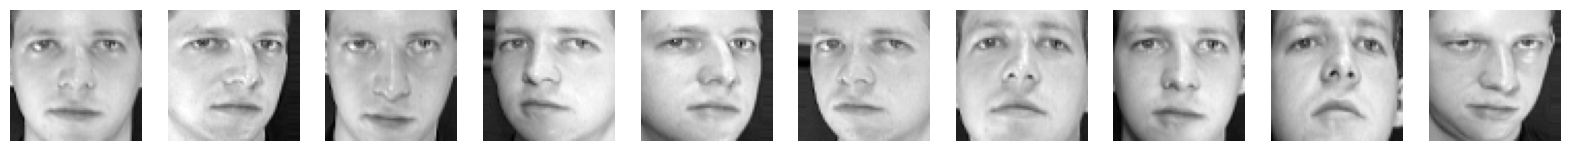

In [58]:
plt.figure(figsize=[20, 5])  # Aumente o tamanho da largura para 20 e altura para 5

for i in range(10):  # Mudando para 10 imagens em vez de 20
    image_row = olivetti_faces.data[i]
    image_reshaped = image_row.reshape(64, 64)
    
    plt.subplot(1, 10, i+1)  # Criar grid para 10 imagens lado a lado
    plt.imshow(image_reshaped, cmap='gray')
    plt.axis('off')  # Esconder os eixos

plt.show()

In [15]:
olivetti = {'data': olivetti_faces.data, 'target': olivetti_faces.target, 'details': {'name':'olivetti-faces'}}

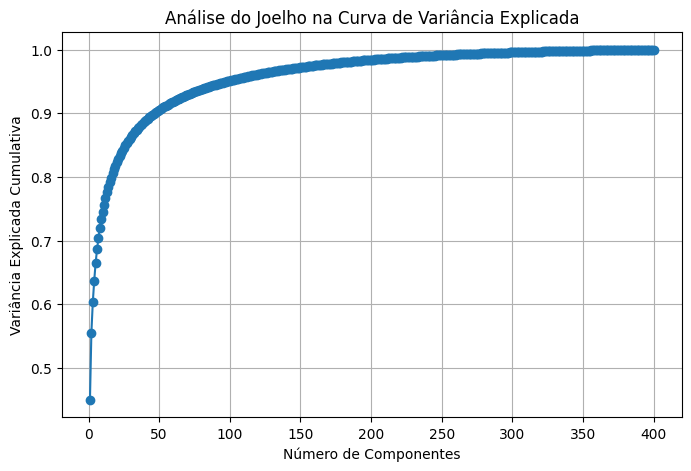

In [60]:
# Supondo que seu DataFrame seja chamado 'data'
# Certifique-se de substituir 'data' pelo nome real do seu DataFrame
X = olivetti_faces['data'].T

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()

# 3D Cube

In [270]:
from matplotlib.pyplot import cm

# Criando uma grade tridimensional
x = np.linspace(-5, 5, 11)  # 11 pontos de -5 a 5
y = np.linspace(-5, 5, 11)
z = np.linspace(-5, 5, 11)
X, Y, Z = np.meshgrid(x, y, z)

# Remodelando para obter um array 3D
X3 = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

X3 = X3.astype(np.float64)

# Parameters
noise_scale = 1  # adjust the noise gaussian parameter here

# Add noise
# Definir a magnitude do ruído gaussiano
magnitude = np.linspace(0,1,11)
# Gerar ruído gaussiano com média zero e desvio padrão baseado na magnitude
ruido = np.random.normal(0, scale=magnitude[0], size=X3.shape)
# Adicionar o ruído aos dados
# Surface equation
X3.T[0] = X3.T[0] + ruido.T[0]
X3.T[1] = X3.T[1] + ruido.T[1]
X3.T[2] = X3.T[2] + ruido.T[2]

n:  1331
ISOMAP
KPCA
LLE
Laplacian Eigenmaps
t-SNE
UMAP
K-ISOMAP


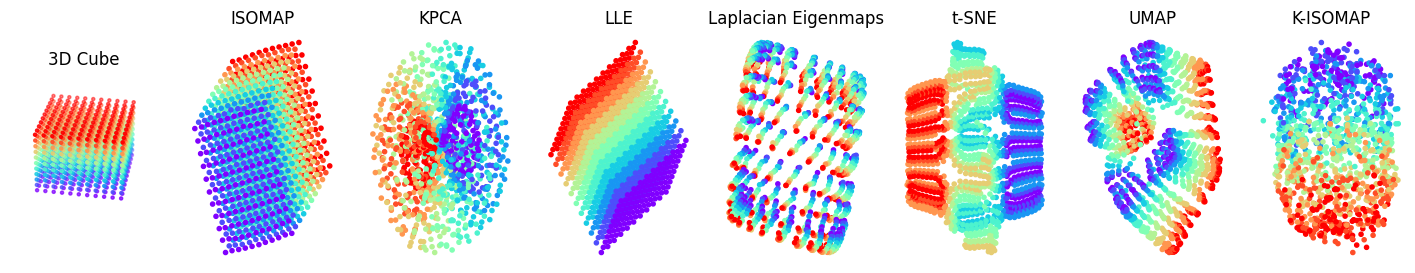

In [271]:
color = [cm.rainbow(valor) for valor in X3.T[2]/10+0.5]

compare_and_plot_surface_reduction(X3,color,'3D Cube')

# Sphere Bowl

In [268]:
# Criando os parâmetros da esfera
num_pontos = 3000  # Número de pontos para gerar
raio = 5


# Gerando variáveis aleatórias normais para as três dimensões
u = np.random.normal(0, 1, num_pontos)
v = np.random.normal(0, 1, num_pontos)
w = np.random.normal(0, 1, num_pontos)

# Gerando a variável exponencial
e = np.random.exponential(0.5, num_pontos)

# Calculando o denominador para a normalização
denom = np.sqrt(u**2 + v**2 + w**2 + e)

# Normalizando as coordenadas para obter pontos na superfície da esfera
x = u / denom
y = v / denom
z = w / denom

# Adiciona ruído gaussiano (se desejado)
#magnitude = 0.00  # Ajuste da magnitude do ruído
#x += np.random.normal(0, magnitude, size=x.shape)
#y += np.random.normal(0, magnitude, size=y.shape)
#z += np.random.normal(0, magnitude, size=z.shape)


X = np.array([x,y,z]).T
X = X[X[:, 2] < 0.5]

n:  2368
ISOMAP
KPCA
LLE
Laplacian Eigenmaps
t-SNE
UMAP
K-ISOMAP


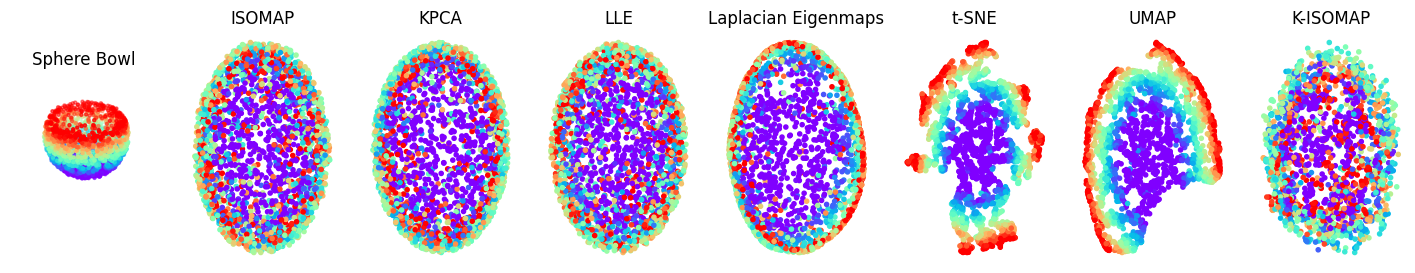

In [269]:
color = [cm.rainbow(valor) for valor in X.T[2]+0.6]
compare_and_plot_surface_reduction(X,color,'Sphere Bowl')

# Linked Torus

In [12]:
# Parameters
u = np.linspace(0, 2*np.pi, 24)
v = np.linspace(0, 2*np.pi, 24)
U, V = np.meshgrid(u, v)

R = 7
r = 1.5

# Torus Surface equation
x = (R+r*np.cos(V))*np.cos(U)
y = (R+r*np.cos(V))*np.sin(U)-7
z = r*np.sin(V)


x_1 = r*np.sin(V) 
y_1 = (R+r*np.cos(V))*np.sin(U) 
z_1 = (R+r*np.cos(V))*np.cos(U)

# Add Gaussian noise with 0.3 standard deviation
np.random.seed(127)
noise_matrix_1 = np.random.normal(0, 0.4, (len(z.flatten()), 3))
data_matrix_1 = np.column_stack((x.flatten(), y.flatten(), z.flatten())) + noise_matrix_1

noise_matrix_2 = np.random.normal(0, 0.4, (len(z_1.flatten()), 3))
data_matrix_2 = np.column_stack((x_1.flatten(), y_1.flatten(), z_1.flatten())) + noise_matrix_2

result_matrix = np.vstack([np.column_stack((data_matrix_1, np.full(len(z.flatten()), 0.0))), 
                          np.column_stack((data_matrix_2, np.full(len(z_1.flatten()), 1.0)))]).astype('float64')

n:  1152
ISOMAP
KPCA
LLE
Laplacian Eigenmaps
t-SNE
UMAP
K-ISOMAP


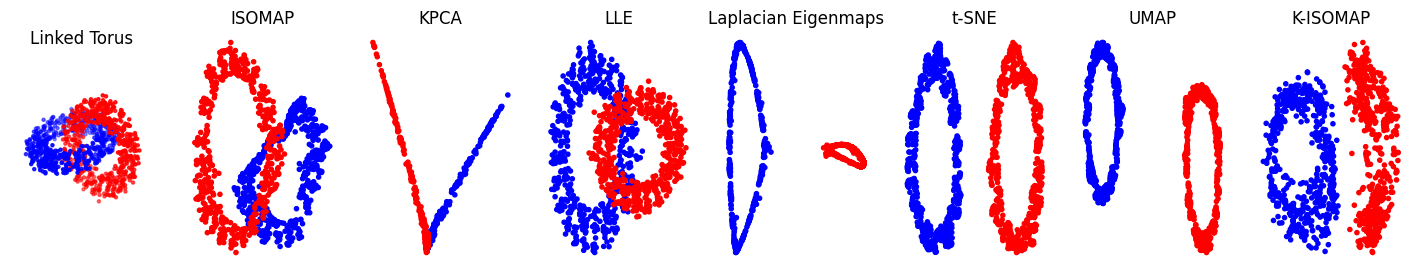

<Figure size 640x480 with 0 Axes>

In [118]:
color =  [cm.bwr(valor) for valor in result_matrix[:,3]]
compare_and_plot_surface_reduction(result_matrix[:,:3],color,'Linked Torus \n')

Number of samples: 1152
value:  0.0
value:  0.1
value:  0.2
value:  0.3
value:  0.4
value:  0.5
value:  0.6
value:  0.7
value:  0.8
value:  0.9


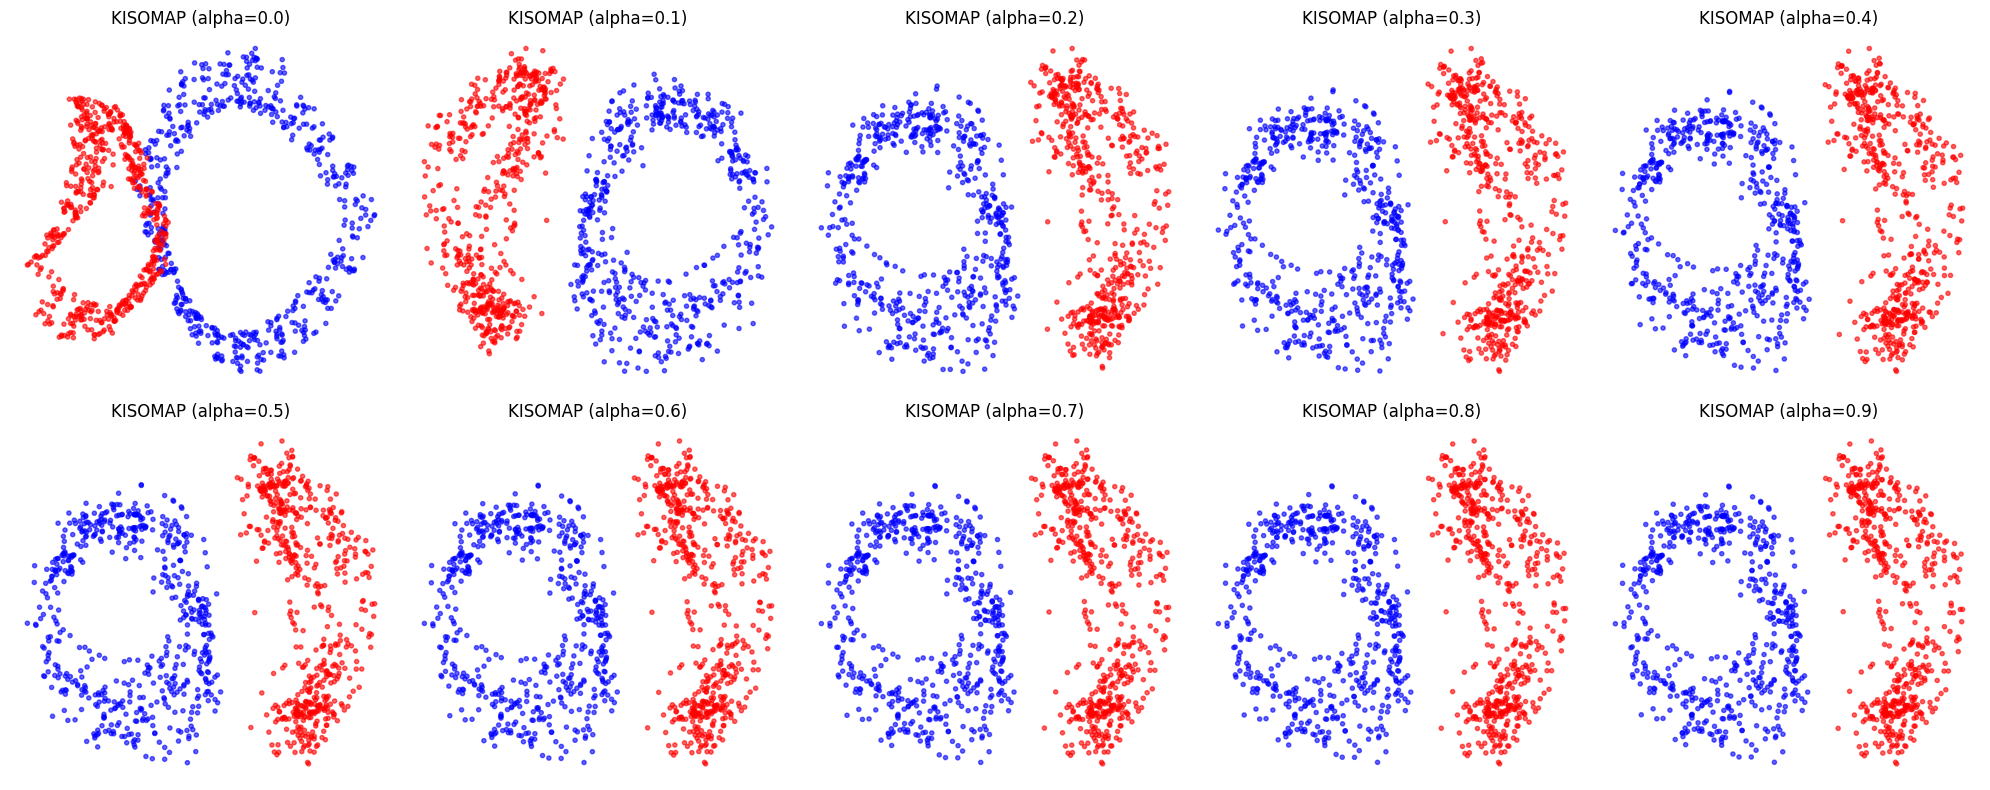

In [13]:
color =  [cm.bwr(valor) for valor in result_matrix[:,3]]
plot_kiso_iterations(result_matrix[:,:3],color,'Linked Torus')

# Swiss Roll

In [20]:
import numpy as np
from sklearn.datasets import make_swiss_roll

# Generate the Swiss Roll dataset with 1500 samples
X2, color = make_swiss_roll(n_samples=1100,hole=False)

X2 = np.array(X2)
# Convert the dataset into a matrix array

In [21]:
my_min_val = np.min(color)
my_max_val = np.max(color)

# Perform min-max normalization
my_normalized_arr = (color - my_min_val) / (my_max_val - my_min_val)

In [22]:
color2 =  [cm.gist_rainbow(valor) for valor in my_normalized_arr]

Number of samples: 1100
value:  0.0
value:  0.1
value:  0.2
value:  0.3
value:  0.4
value:  0.5
value:  0.6
value:  0.7
value:  0.8
value:  0.9


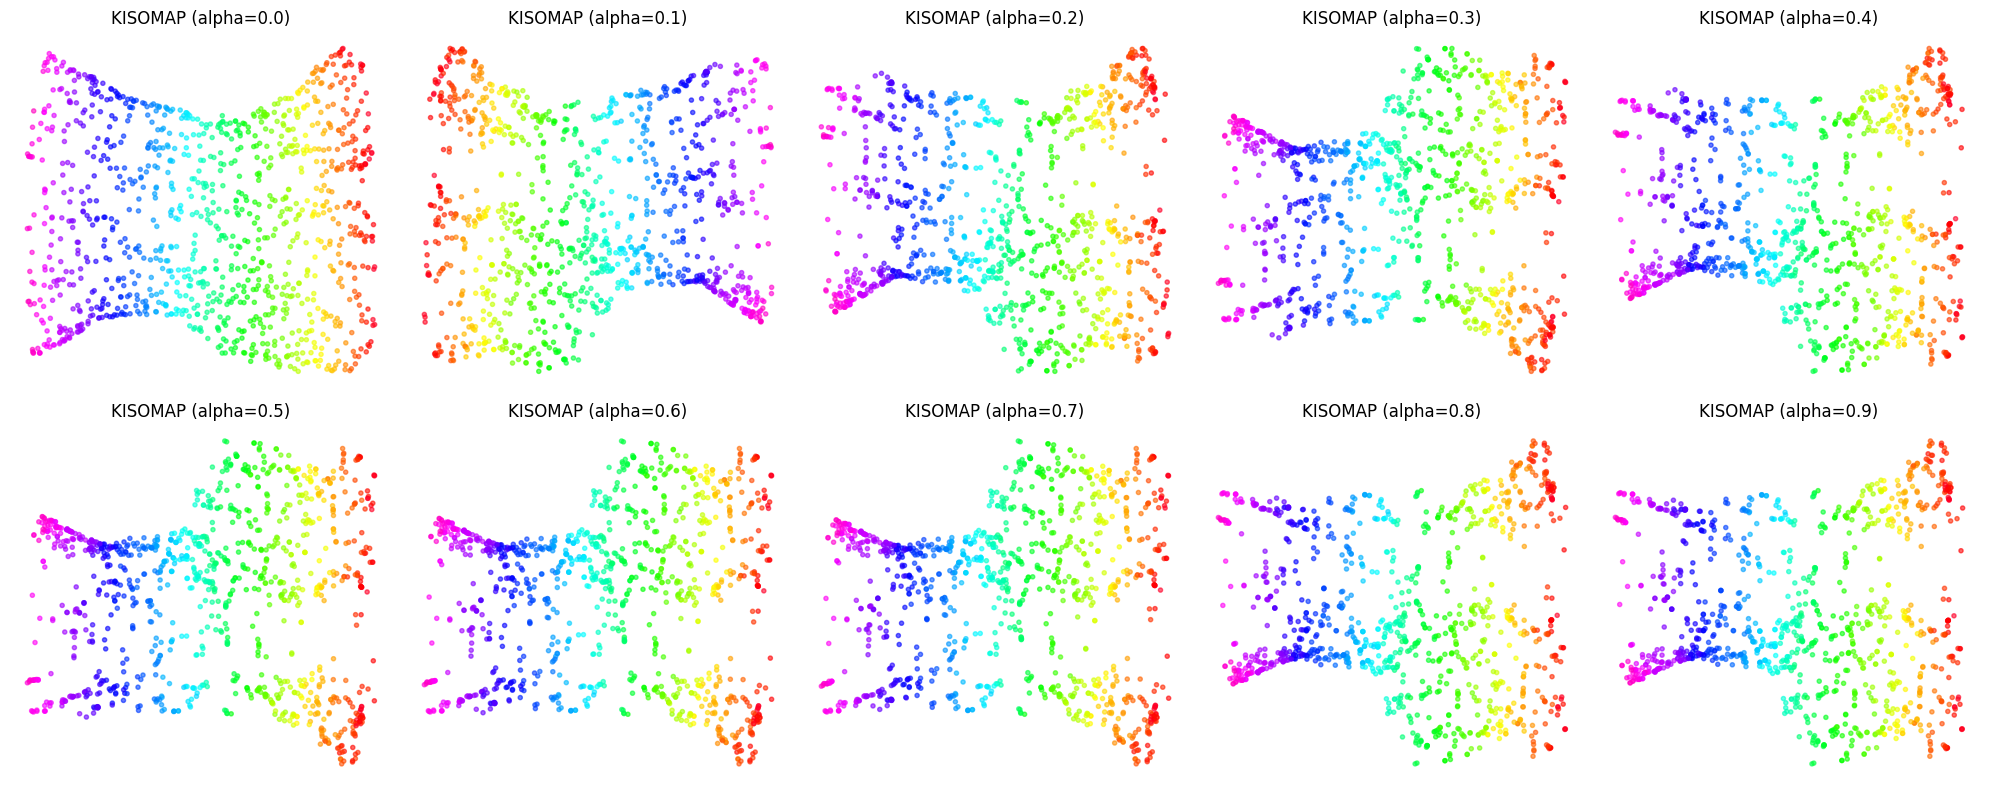

In [23]:
plot_kiso_iterations(X2,color2,'Swiss Roll')

n:  2000
0
1
2
3
4
5
6
7
8
9
10


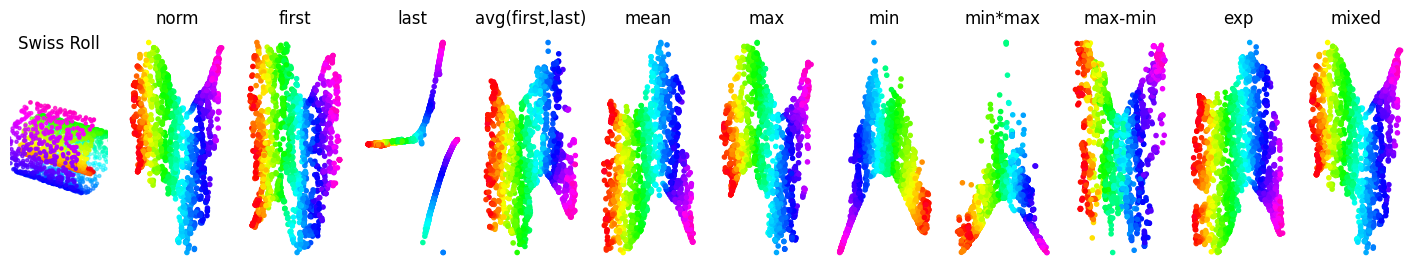

<Figure size 640x480 with 0 Axes>

In [122]:
compare_and_plot_option_kisomap(X2,color2,'Swiss Roll')

# 3D Plots

In [514]:
import matplotlib.colors as mcolors

'''
Produces scatter plots of the 2D mappings
'''
def PlotaDados3D(dados, labels, metodo):
    # Number of classes
    nclass = len(np.unique(labels))
    
    # Converts list to an array (if needed)
    rotulos = np.array(labels)
    
    # Define colors according to the number of classes
    if nclass > 11:
        cores = list(mcolors.CSS4_COLORS.keys())
        #np.random.shuffle(cores)
    else:
        cores = [
            'blue', 'red', 'cyan', 'black', 'orange', 'magenta', 'green',
            'darkkhaki', 'brown', 'purple', 'salmon'
        ]
    
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(nclass):
        indices = np.where(rotulos == i)[0]
        cor = cores[i % len(cores)]  # Ensures no index out of range
        ax.scatter(dados[indices, 0], dados[indices, 1], dados[indices, 2], c=cor, label=f'Class {i}', marker='*')
    
    # Add title and legend
    #plt.title(f'{metodo} clusters')
    
    # Save figure to file
    nome_arquivo = f'{metodo}_gmm.png'
    plt.savefig(nome_arquivo, dpi=1200)
    plt.show()

In [510]:
pca = PCA(n_components=100)
dados_pca = pca.fit_transform(coil_20['data'])

In [ ]:
coil_20['target']

n:  1440
ISOMAP
KPCA
LLE
Laplacian Eigenmaps
t-SNE
UMAP
K-ISOMAP


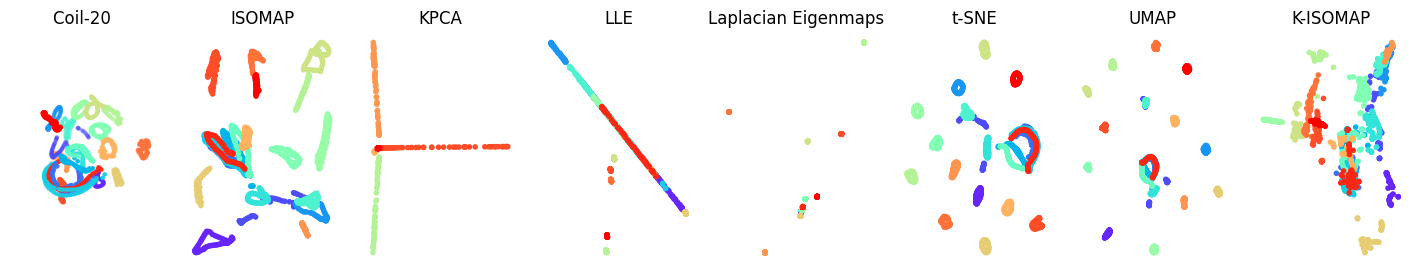

<Figure size 640x480 with 0 Axes>

In [516]:
color =  [cm.rainbow(valor) for valor in coil_20['target']/20]
compare_and_plot_surface_reduction(tsne_data,color,'Coil-20 \n')

In [511]:
model = TSNE(n_components=3)

In [512]:
tsne_data = model.fit_transform(dados_pca)

In [38]:
labels_gmm = GaussianMixture(n_components=20, random_state=42).fit_predict(tsne_data)

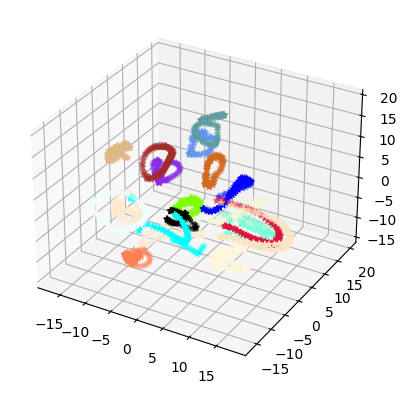

In [519]:
PlotaDados3D(tsne_data,coil_20['target'],'coil-20_t-SNE')

# Teste com o Constrained K-ISOMAP

A ideia é saber se, ao restringir a quantidade de componentes utilizadas no cálculo do vetor de curvaturas, estaremos melhorando a performance do algoritmo e/ou reduzindo ruído de curvatura de outras componentes.